My implementation of the Transformer model proposed in the original Transformer paper [@VaswaniSPUJGKP17] in PyTorch.

<p style="text-align:center;">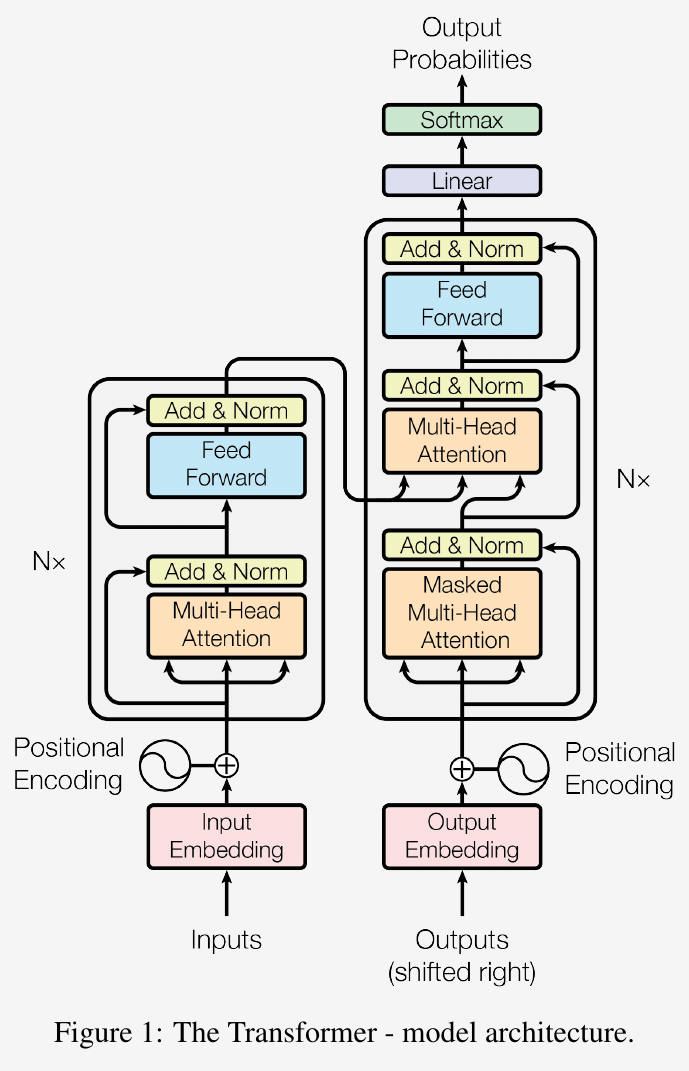
<br/>Image source: Vaswani et al. [@VaswaniSPUJGKP17]</p>

## The components of the Transformer architecture
### Attention
#### Scaled dot-product attention
It's computed as a weighted sum of the values,

$$
\mathrm{Attention}(Q, K, V) = softmax(\frac{QK^\top}{\sqrt{d_k}})V
$$

In [1]:
import torch
import torch.nn as nn

In [2]:
def scaled_dot_product_attention(q, k, v, mask, dropout):
    # q: (batch_size, n_heads, q_length, dim_key)
    # k: (batch_size, n_heads, k_length, dim_key)
    # v: (batch_size, n_heads, k_length, dim_value)
    # mask:
    #   encoder self-attn: (batch_size, 1, 1, k_length)
    #   decoder self-attn: (batch_size, 1, q_length, k_length)
    #   decoder cross-attn: (batch_size, 1, 1, k_length)

    scores = torch.matmul(
        q, k.transpose(-2, -1)
    ) / torch.math.sqrt(k.size(-1)) # (batch_size, n_heads, q_length, k_length)

    if mask is not None:
        scores = scores.masked_fill(mask==0, value=-1e10)

    attention_weights = scores.softmax(dim=-1) # (batch_size, n_heads, q_length, k_length)
    
    if dropout is not None:
        attentions = dropout(attention_weights)
    attentions = torch.matmul(attentions, v) # (batch_size, n_heads, q_length, dim_value)

    return attentions, attention_weights

#### Multi-head attention
Multi-head attention computes attention functions on multiple projections of the input queries, keys and values.
This allows the model to capture different features of the input data from different subspaces and at different locations.
The output of each attention function is then concatenated and projected to produce the final values.

$$
\mathrm{MultiHead}(Q,K,V)=\mathrm{Concat}(head_1, \dots, head_h)W^O
$$
$$
where\ \mathrm{head_i}=\mathrm{Attention}(QW_i^Q,KW_i^K,VW_i^V)
$$
$$
W_i^Q \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W_i^V \in \mathbb{R}^{d_{model} \times d_v}, W_i^O \in \mathbb{R}^{hd_v \times d_{model}}
$$

In [3]:
class MultiheadAttention(nn.Module):
    def __init__(self, n_heads, dim_model, dim_value, dropout_p):
        super().__init__()

        self.dim_model = dim_model
        self.n_heads = n_heads
        self.dim_value = dim_value
        # dim_model should be divisible by n_heads
        # the values from the paper are: dim_value=512, n_heads=8
        assert dim_model % n_heads == 0, 'Invalid values: dim_model should be divisible by n_heads.'
        self.dim_key = dim_model // n_heads

        # q, k, v projections
        self.wq = nn.Linear(dim_model, dim_model)
        self.wk = nn.Linear(dim_model, dim_model)
        self.wv = nn.Linear(dim_model, n_heads*dim_value)

        self.wo = nn.Linear(n_heads*dim_value, dim_model)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, q, k, v, mask):
        query = self.wq(q) # (batch_size, q_length, dim_model)
        
        # key and value will have the same sequence length
        key = self.wk(k) # (batch_size, k_length, dim_model)
        value = self.wv(v) # (batch_size, k_length, dim_model)

        query = query.view(
            query.size(0), query.size(1), self.n_heads, self.dim_key
        ).transpose(1, 2) # (batch_size, n_heads, q_length, dim_key)
        key = key.view(
            key.size(0), key.size(1), self.n_heads, self.dim_key
        ).transpose(1, 2) # (batch_size, n_heads, k_length, dim_key)
        value = value.view(
            value.size(0), value.size(1), self.n_heads, self.dim_value
        ).transpose(1, 2) # (batch_size, n_heads, k_length, dim_value)

        attentions, attention_weights = scaled_dot_product_attention(
            query, key, value, mask, self.dropout
        )

        attentions = attentions.transpose(1, 2).contiguous() # (batch_size, q_length, n_heads, dim_value)
        attentions = attentions.view(
            attentions.size(0), attentions.size(1), -1
        ) # (batch_size, q_length, n_heads*dim_value)
        attentions = self.wo(attentions)

        # attentions: (batch_size, q_length, dim_model)
        # attention_weights: (batch_size, n_heads, q_length, k_length)
        return attentions, attention_weights

### Position-wise Feed-Forward Networks
Contains 2 linear layers with a ReLU activation in between,
$$
\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2
$$

In [4]:
class FFN(nn.Module):
    def __init__(self, dim_model, dim_ffn, dropout_p):
        super().__init__()
        self.linear1 = nn.Linear(dim_model, dim_ffn)
        self.linear2 = nn.Linear(dim_ffn, dim_model)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### Embedding & Positional Encoding
Embeddings are learned. Embedding weights are multiplied by $\sqrt{d_{model}}$ .

In [5]:
class Embeddings(nn.Module):
    def __init__(self, dim_model, vocab_size):
        super().__init__()
        self.dim_model = dim_model
        self.embedding = nn.Embedding(vocab_size, dim_model)

    def forward(self, x):
        # x: (batch_size, seq_length)
        x = self.embedding(x) # (batch_size, seq_length, dim_model)
        x = x * torch.math.sqrt(self.dim_model)
        return x

Positional encoding is used to inject information about positions of the tokens in the sequence.
It's computed using a combination of sine and cosine functions,
$$
\begin{aligned}
PE_{(pos, 2i)} &=sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &=cos(pos/10000^{2i/d_{model}})
\end{aligned}
$$
where $pos$ is the position, and $i$ is the dimension.

Since it's more efficient to compute power in log space, the term of denominator can be calculated as,
$$
\begin{aligned}
u &= e^{ln(u)}, \mathrm{where}\ u= 1/10000^{2i/d_{model}}  \\
ln(u) &= 2i(-ln(10000)/d_{model}) \\
u &= e^{2i(-ln(10000)/d_{model})}
\end{aligned}
$$

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_length, dim_model, dropout_p):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)

        pe = torch.zeros(max_seq_length, dim_model) # (max_seq_length, dim_model)
        positions = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) # (max_seq_length, 1)
        u = torch.exp(
            torch.arange(0, dim_model, 2).float() * (-torch.math.log(10000.0) / dim_model)
        ) # (max_seq_length,)
        pe[:, 0::2] = torch.sin(positions * u)
        pe[:, 1::2] = torch.cos(positions * u)
        pe = pe.unsqueeze(0) # (1, max_seq_length, dim_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_length, dim_model)
        x = x + (self.pe[:, :x.size(1), :]).requires_grad_(False)
        return self.dropout(x) # (batch_size, seq_length, dim_model)

### Add & Norm
This is done by applying a residual connection around sublayers (multihead attention layer, FFN layer), and then a layer normalization, i.e., $$\mathrm{LayerNorm}(x+\mathrm{Sublayer}(x))$$

Layer normalization is computed as,
$$
y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
$$
where $\gamma$ and $\beta$ are learnable parameters. The PyTorch implementation is `nn.LayerNorm`.

In [7]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout_p):
        super().__init__()
        self.layernorm = nn.LayerNorm(normalized_shape=normalized_shape)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, sublayer_output):
        return self.layernorm(x + self.dropout(sublayer_output))

### Encoder
Encoder creates a sequence of context vectors corresponding to input tokens.

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attn, ffn, dropout_p):
        super().__init__()
        self.self_attn = self_attn
        self.ffn = ffn
        self.add_norm = nn.ModuleList(
            [AddNorm(self_attn.dim_model, dropout_p) for _ in range(2)]
        )

    def forward(self, x, src_mask):
        # x: (batch_size, src_length, dim_model)
        # src_mask: (batch_size, 1, 1, src_length)
        sublayer_output, _ = self.self_attn(x, x, x, src_mask)
        x = self.add_norm[0](x, sublayer_output) # (batch_size, src_length, dim_model)
        x = self.add_norm[1](x, self.ffn(x)) # (batch_size, src_length, dim_model)
        return x


class Encoder(nn.Module):
    def __init__(self, N, n_heads, dim_model, dim_value, dim_ffn, dropout_p):
        super().__init__()

        self.blocks = nn.ModuleList()
        for _ in range(N):
            encoder_block = EncoderBlock(
                MultiheadAttention(n_heads, dim_model, dim_value, dropout_p),
                FFN(dim_model, dim_ffn, dropout_p),
                dropout_p
            )
            self.blocks.append(encoder_block)

    def forward(self, x, src_mask):
        # x: (batch_size, src_length, dim_model)
        # src_mask: (batch_size, 1, 1, src_length)
        for block in self.blocks:
            x = block(x, src_mask)
        return x # (batch_size, src_length, dim_model)

### Decoder
Decoder takes the context vectors from the encoder to produce output tokens. It has a masked self-attention layer and also a cross-attention layer over the encoder output.

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attn, cross_attn, ffn, dropout_p):
        super().__init__()
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.ffn = ffn
        self.add_norm = nn.ModuleList(
            [AddNorm(self_attn.dim_model, dropout_p) for _ in range(3)]
        )

    def forward(self, x, tgt_mask, encoder_memory, src_mask):
        # x: (batch_size, tgt_length, dim_model)
        # tgt_mask: (batch_size, 1, tgt_length, tgt_length)
        # encoder_memory: (batch_size, src_length, dim_model)
        # src_mask: (batch_size, 1, 1, src_length)
        sublayer_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.add_norm[0](x, sublayer_output) # (batch_size, tgt_length, dim_model)
        
        sublayer_output, attention_weights = self.cross_attn(x, encoder_memory, encoder_memory, src_mask)
        x = self.add_norm[1](x, sublayer_output) # (batch_size, tgt_length, dim_model)
        
        x = self.add_norm[2](x, self.ffn(x))

        # attention_weights: (batch_size, n_heads, tgt_length, src_length)
        # x: (batch_size, tgt_length, dim_model)
        return x, attention_weights


class Decoder(nn.Module):
    def __init__(self, N, n_heads, dim_model, dim_value, dim_ffn, dropout_p):
        super().__init__()

        self.blocks = nn.ModuleList()
        for _ in range(N):
            decoder_block = DecoderBlock(
                MultiheadAttention(n_heads, dim_model, dim_value, dropout_p),
                MultiheadAttention(n_heads, dim_model, dim_value, dropout_p),
                FFN(dim_model, dim_ffn, dropout_p),
                dropout_p
            )
            self.blocks.append(decoder_block)

    def forward(self, x, tgt_mask, encoder_memory, src_mask):
        for block in self.blocks:
            x, attention_weights = block(x, tgt_mask, encoder_memory, src_mask)

        return x, attention_weights

### Model head
A learned linear projection.

In [10]:
class ModelHead(nn.Module):
    def __init__(self, dim_model, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dim_model, vocab_size)

    def forward(self, x):
        return self.linear(x)

## The Transformer model
Put everything together.

In [11]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, model_head, src_pad_token_id, tgt_pad_token_id):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.model_head = model_head
        self.src_pad_token_id = src_pad_token_id
        self.tgt_pad_token_id = tgt_pad_token_id

    def get_src_mask(self, src_input):
        # src_input: (batch_size, src_length)
        src_mask = (
            src_input != self.src_pad_token_id
        ).unsqueeze(1).unsqueeze(1).int()
        
        return src_mask # src_mask: (batch_size, 1, 1, src_length)

    def get_tgt_mask(self, tgt_input):
        # tgt_input: (batch_size, tgt_length)
        tgt_padding_mask = (
            tgt_input != self.tgt_pad_token_id
        ).unsqueeze(1).unsqueeze(1).int() # tgt_padding_mask: (batch_size, 1, 1, tgt_length)
        
        tgt_decoding_mask = torch.tril(
            torch.ones(tgt_input.size(1), tgt_input.size(1))
        ).unsqueeze(0).unsqueeze(0).int().to(tgt_input.device) # tgt_decoding_mask: (1, 1, tgt_length, tgt_length)
        
        tgt_mask = tgt_padding_mask & tgt_decoding_mask

        return tgt_mask # tgt_mask: (batch_size, 1, tgt_length, tgt_length)

    def forward(self, src_input, tgt_input):
        # src_input: (batch_size, src_length)
        # tgt_input: (batch_size, tgt_length)

        src_mask = self.get_src_mask(src_input)
        encoder_output = self.encoder(
            self.src_embed(src_input), # (batch_size, src_length, dim_model)
            src_mask # (batch_size, 1, 1, src_length)
        ) # (batch_size, src_length, dim_model)
        
        tgt_mask = self.get_tgt_mask(tgt_input)
        decoder_output, attention_weights = self.decoder(
            self.tgt_embed(tgt_input), # (batch_size, tgt_length, dim_model)
            tgt_mask, # (batch_size, 1, tgt_length, tgt_length)
            encoder_output, # (batch_size, src_length, dim_model)
            src_mask # (batch_size, 1, 1, src_length)
        ) # (batch_size, tgt_length, dim_model)
        
        output = self.model_head(decoder_output) # (batch_size, tgt_length, tgt_vocab_size)
        
        return output, attention_weights

## Training

### 1. load & prepare data for training
#### 1.1. load data
Use the Multi30k dataset [@elliott-EtAl:2016:VL16], which contains translations from English to German. It has 3 splits: train, validation and test.

In [12]:
from datasets import load_dataset

train_ds, val_ds, test_ds = load_dataset('bentrevett/multi30k', split=['train', 'validation', 'test'])
print(train_ds, val_ds, test_ds)
train_ds[0]

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})


{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

#### 1.2. init tokenizers & build vocabularies
`Spacy` is a good choice for multilingual tokenization.

In [13]:
import spacy
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator

In [14]:
# languages
EN = 'en'
DE = 'de'
# special tokens
PAD = '<pad>'
UNK = '<unk>'
SOS = '<sos>'
EOS = '<eos>'

tokenizers = {EN: spacy.load('en_core_web_sm').tokenizer,
              DE: spacy.load('de_core_news_sm').tokenizer}

In [15]:
def tokenize_sentence(sentence, tokenizers, lang):
    return [token.text for token in tokenizers[lang](sentence)]

def get_tokens(ds, tokenizers, lang):
    for sample in ds:
        yield tokenize_sentence(sample[lang], tokenizers, lang)

Tokenize the first sample.

In [16]:
print(next(get_tokens(train_ds, tokenizers, EN)))
print(next(get_tokens(train_ds, tokenizers, DE)))

['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']


Build vocabularies for both English and German.

In [17]:
en_vocab = build_vocab_from_iterator(
    get_tokens(train_ds, tokenizers, EN),
    min_freq=2,
    specials=[PAD, UNK, SOS, EOS])
en_vocab.set_default_index(en_vocab[UNK])

de_vocab = build_vocab_from_iterator(
    get_tokens(train_ds, tokenizers, DE),
    min_freq=2,
    specials=[PAD, UNK, SOS, EOS])
de_vocab.set_default_index(de_vocab[UNK])

vocabs = {EN: en_vocab, DE: de_vocab}
print(f'EN vocab size: {len(en_vocab)}\nDE vocab size: {len(de_vocab)}')

EN vocab size: 6191
DE vocab size: 8014


#### 1.3. tokenize and transform data

In [18]:
def tokenize_data(vocabs, tokenizers):
    transforms = dict()
    for lang, vocab in vocabs.items():
        transforms[lang] = T.Sequential(
            T.VocabTransform(vocab),
            T.AddToken(vocab[SOS], begin=True),
            T.AddToken(vocab[EOS], begin=False)
        )

    def process(sample):
        result = dict()
        for lang, sentence in sample.items():
            result[lang] = transforms[lang](
                [token.text for token in tokenizers[lang](sentence)]
            )
        return result

    return process

In [19]:
tokenized_train_ds = train_ds.map(tokenize_data(vocabs, tokenizers))
tokenized_val_ds = val_ds.map(tokenize_data(vocabs, tokenizers))
tokenized_test_ds = test_ds.map(tokenize_data(vocabs, tokenizers))

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
print(tokenized_train_ds, tokenized_val_ds, tokenized_test_ds)

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})


The first training sample.

In [21]:
tokenized_train_ds[0]

{'en': [2, 19, 25, 15, 1169, 808, 17, 57, 84, 336, 1339, 5, 3],
 'de': [2, 21, 85, 257, 31, 87, 22, 94, 7, 16, 112, 7910, 3209, 4, 3]}

Decode token ids to words.

In [22]:
def decode_tokens(ids, vocab):
    words_list = vocab.get_itos()
    s = [words_list[id] for id in ids]
    return ' '.join(s)

In [23]:
decode_tokens(tokenized_train_ds[0][EN], vocabs[EN])

'<sos> Two young , White males are outside near many bushes . <eos>'

In [24]:
decode_tokens(tokenized_train_ds[0][DE], vocabs[DE])

'<sos> Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche . <eos>'

#### 1.4. init dataloaders

In [25]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [26]:
def get_collate_fn(vocabs):
    """
    Dynamically padding to the max length of the batch.
    """
    def collate_fn(batch):
        langs = list(batch[0].keys())
        src_lang = langs[0]
        tgt_lang = langs[1]
        
        src_batch = []
        tgt_batch = []
        label_batch = []
        for row in batch:
            src_batch.append(torch.tensor(row[src_lang]))
            tgt_batch.append(torch.tensor(row[tgt_lang])[:-1])
            label_batch.append(torch.tensor(row[tgt_lang])[1:])
        
        src_batch = pad_sequence(src_batch, batch_first=True, padding_value=vocabs[src_lang][PAD])
        tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=vocabs[tgt_lang][PAD])
        label_batch = pad_sequence(label_batch, batch_first=True, padding_value=vocabs[tgt_lang][PAD])

        return src_batch, tgt_batch, label_batch

    return collate_fn

In [27]:
train_dataloader = DataLoader(tokenized_train_ds, batch_size=64, shuffle=True, collate_fn=get_collate_fn(vocabs))
val_dataloader = DataLoader(tokenized_val_ds, batch_size=64, shuffle=True, collate_fn=get_collate_fn(vocabs))

Take a quick look at a sample

In [28]:
batch = next(iter(train_dataloader))

print(f'Source: {decode_tokens(batch[0][0], vocabs[EN])}\n')
print(f'Target: {decode_tokens(batch[1][0], vocabs[DE])}\n')
print(f'Label: {decode_tokens(batch[2][0], vocabs[DE])}')

Source: <sos> A woman looks down from a high point above a calm blue ocean . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Target: <sos> Eine Frau blickt von einem hohen Aussichtspunkt über den ruhigen blauen Ozean . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Label: Eine Frau blickt von einem hohen Aussichtspunkt über den ruhigen blauen Ozean . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


### 2. train

In [29]:
from tqdm import tqdm

In [30]:
def build_model(src_vocab_size,
                tgt_vocab_size,
                max_seq_length,
                src_pad_token_id,
                tgt_pad_token_id,
                dim_model=512,
                dim_value=64,
                dim_ffn=2048,
                n_heads=8,
                N=6,
                dropout_p=0.1):
    src_embed = nn.Sequential(
        Embeddings(dim_model, src_vocab_size),
        PositionalEncoding(max_seq_length, dim_model, dropout_p)
    )
    tgt_embed = nn.Sequential(
        Embeddings(dim_model, tgt_vocab_size),
        PositionalEncoding(max_seq_length, dim_model, dropout_p)
    )
    encoder = Encoder(N, n_heads, dim_model, dim_value, dim_ffn, dropout_p)
    decoder = Decoder(N, n_heads, dim_model, dim_value, dim_ffn, dropout_p)
    model_head = ModelHead(dim_model, tgt_vocab_size)

    model = Transformer(encoder, decoder, src_embed, tgt_embed, model_head, src_pad_token_id, tgt_pad_token_id)

    # initialize parameters with Xavier uniform.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model

In [31]:
def run_one_epoch(model, dataloader, optimizer, loss_fn, device):
    if device.type=='cuda':
        torch.cuda.empty_cache()
    model.train()

    total_loss = 0
    for batch in dataloader:
        src_input = batch[0].to(device)
        tgt_input = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        output, _ = model(src_input, tgt_input)
        loss = loss_fn(
            output.view(-1, output.size(-1)),
            labels.view(-1)
        )
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        dataloader.set_postfix({'training loss': f'{loss.item():8.4f}'})

    return total_loss / len(dataloader)

def evaluation(model, dataloader, loss_fn, device):
    model.eval()
    
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            src_input = batch[0].to(device)
            tgt_input = batch[1].to(device)
            labels = batch[2].to(device)

            output, _ = model(src_input, tgt_input)
            loss = loss_fn(
                output.view(-1, output.size(-1)),
                labels.view(-1)
            )

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [32]:
# find out the max sequence length that is required by the model's positional encoding
def get_max_length(datasets):
    max_len = 0
    for ds in datasets:
        for sample in ds:
            for _, ids in sample.items():
                max_len = max(max_len, len(ids))
    return max_len

In [33]:
max_seq_length = get_max_length([tokenized_train_ds, tokenized_val_ds, tokenized_test_ds])
max_seq_length

46

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_model(
    len(vocabs[EN]),
    len(vocabs[DE]),
    max_seq_length,
    vocabs[EN][PAD],
    vocabs[DE][PAD]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-9)
loss_fn = nn.CrossEntropyLoss(
    ignore_index=vocabs[DE][PAD],
    label_smoothing=0.1
).to(device)

def total_params(model):
    return sum([param.numel() for param in model.parameters() if param.requires_grad])

print(f'Total parameters: {total_params(model):,}')

Total parameters: 55,522,638


In [35]:
epochs = 6

training_losses = []
val_losses = []
for epoch in range(epochs):
    train_iterator = tqdm(train_dataloader, desc=f'epoch {epoch:02d}')
    avg_loss = run_one_epoch(model, train_iterator, optimizer, loss_fn, device)
    training_losses.append(avg_loss)
    # get validation loss
    avg_loss = evaluation(model, val_dataloader, loss_fn, device)
    val_losses.append(avg_loss)

epoch 05: 100%|██████████| 454/454 [00:26<00:00, 17.03it/s, training loss=3.3311]


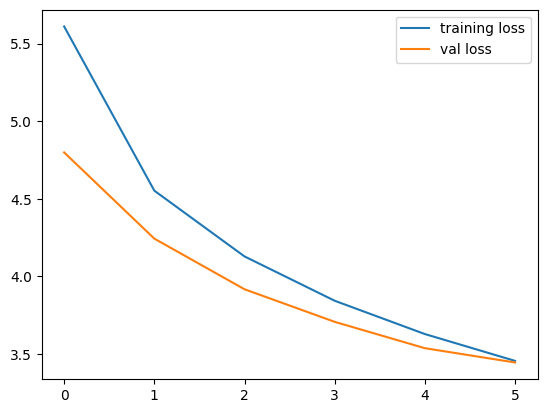

In [36]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label='training loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show();

## Inference
During inference, tokens are generated one at a time.

In [37]:
def translate(sample, max_gen_length=50):
    process_fn = tokenize_data(vocabs, tokenizers)
    sample_ids = process_fn(sample)
    
    model.eval()
    
    # compute context vectors
    src_input = sample_ids[EN]
    src_input = torch.LongTensor(src_input).unsqueeze(0).to(device)
    src_mask = model.get_src_mask(src_input)
    with torch.no_grad():
        encoder_output = model.encoder(model.src_embed(src_input), src_mask)

    # generate output tokens
    translation = []
    tgt_input = [vocabs[DE][SOS]]
    tgt_input = torch.LongTensor(tgt_input).unsqueeze(0).to(device)
    for _ in range(max_gen_length):
        tgt_mask = model.get_tgt_mask(tgt_input)
        with torch.no_grad():
            decoder_output, attention_weights = model.decoder(
                model.tgt_embed(tgt_input),
                tgt_mask,
                encoder_output,
                src_mask
            )
            output = model.model_head(decoder_output)
        
        pred = output.argmax(-1)[:, -1] # the last token is the predicted
        if pred.item() == vocabs[DE][EOS]:
            # reached <eos> token
            break
    
        translation.append(pred.item())
        tgt_input = torch.cat((tgt_input, pred.unsqueeze(0)), dim=-1)
    return translation, attention_weights

In [38]:
de_words_list = vocabs[DE].get_itos()

In [39]:
sample = test_ds[0]

translation, attention_weights = translate(sample)
translation = ' '.join([de_words_list[id] for id in translation])

print(f'label: {sample[DE]}\npreds: {translation}')

label: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
preds: Ein Mann mit einem Hut schaut auf einen Tisch .


## Visualize attentions

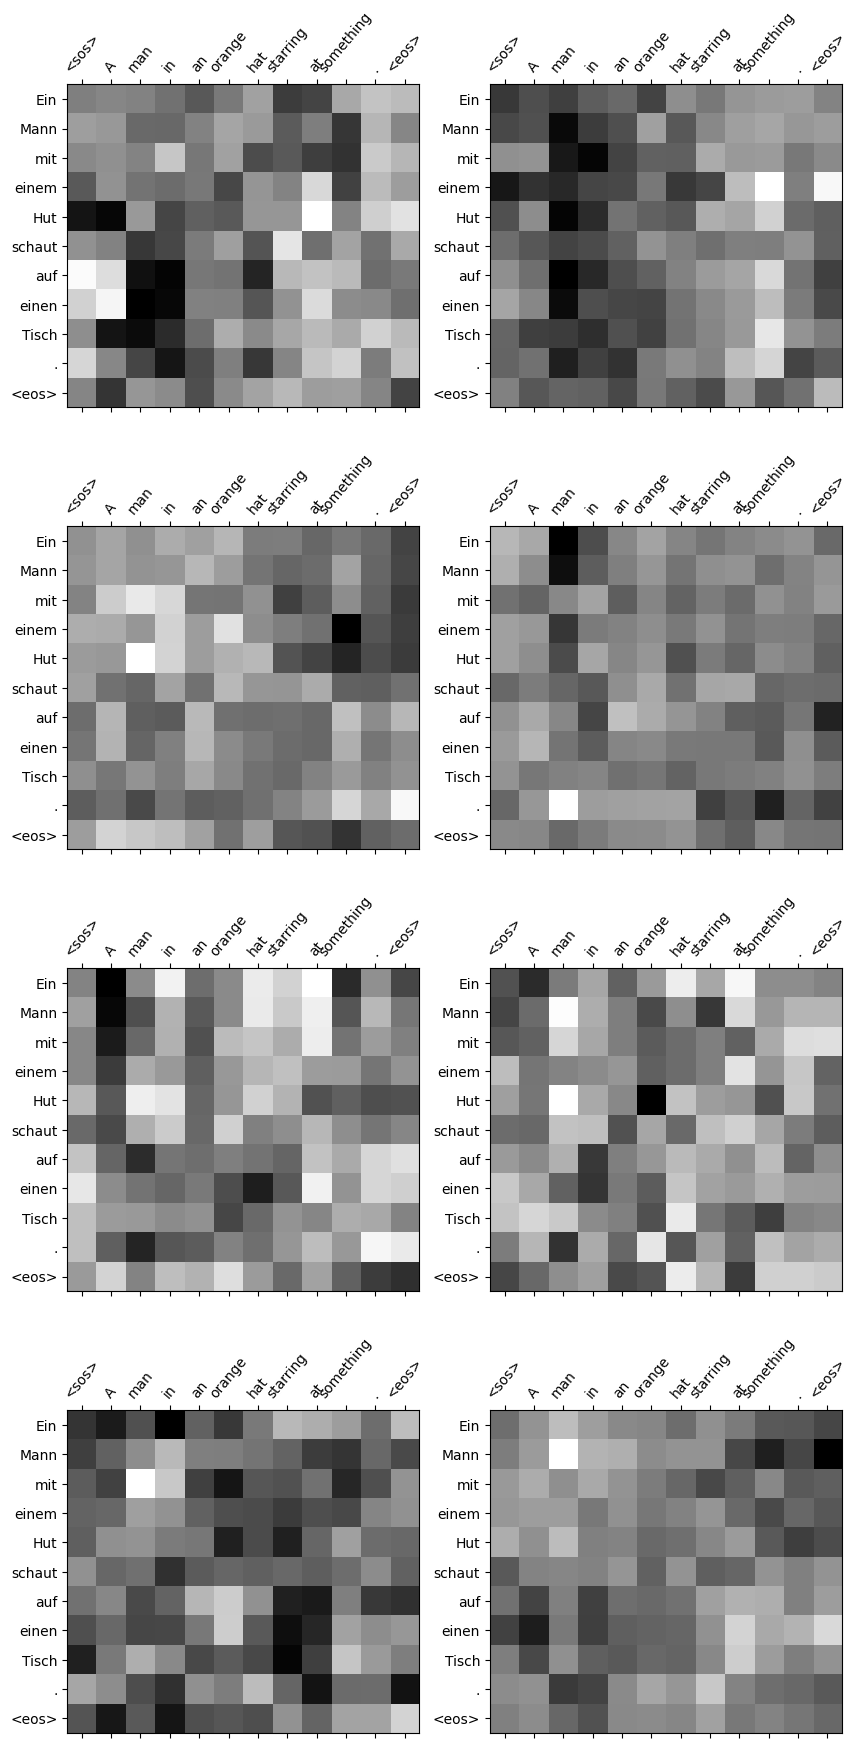

In [40]:
en_words = ['<sos>']+tokenize_sentence(sample[EN], tokenizers, EN)+['<eos>']
de_words = translation.split(' ')+['<eos>']
values = attention_weights.detach().cpu().numpy().squeeze(0)

fig = plt.figure(figsize=(10,22))
xticks = list(range(len(en_words)))
yticks = list(range(len(de_words)))
for i in range(8):
    ax = fig.add_subplot(4, 2, i+1)
    ax.matshow(values[i], cmap='gray')
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(en_words, rotation=50)
    ax.set_yticks(yticks)
    ax.set_yticklabels(de_words)

plt.show()